# Project Setup and Introduction

"""
# Irish Landmark Recognition - Data Collection & Preprocessing

## Project Overview
This notebook handles the collection and preprocessing of Irish landmark images 
for our deep learning classification model.

**Research Question:** Can deep CNNs accurately classify famous Irish landmarks 
from tourist photographs using transfer learning?

**Target Landmarks:**
1. Cliffs of Moher (County Clare)
2. Giant's Causeway (County Antrim) 
3. Ring of Kerry (County Kerry)
4. Dublin Castle (Dublin)
5. Killarney National Park (County Kerry)
6. Rock of Cashel (County Tipperary)

**Goals:**
- Collect 150+ images per landmark
- Clean and preprocess images
- Create train/validation splits
- Generate dataset statistics
"""


In [62]:
# CELL 2: Import Libraries and Dependencies
import requests
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFile
import urllib.request
from pathlib import Path
import shutil
from tqdm import tqdm
import warnings
import json
from collections import defaultdict
import random
from sklearn.model_selection import train_test_split

# Selenium imports
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException

# WebDriver manager for automatic driver management
try:
    from webdriver_manager.chrome import ChromeDriverManager
    print("WebDriver manager available")
except ImportError:
    print("Install webdriver-manager: pip install webdriver-manager")

# Image processing setup
ImageFile.LOAD_TRUNCATED_IMAGES = True
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("All libraries imported successfully!")
print(f"Current working directory: {os.getcwd()}")

WebDriver manager available
All libraries imported successfully!
Current working directory: c:\Github\Business-Intelligence---Business-Analytics


In [63]:
# CELL 3: Project Configuration and Setup
class Config:
    """Enhanced project configuration with scraping settings"""
    
    # Directory structure
    BASE_DIR = Path(".")
    DATA_DIR = BASE_DIR / "data"
    RAW_DIR = DATA_DIR / "raw"
    PROCESSED_DIR = DATA_DIR / "processed"
    
    # Scraping settings
    IMAGES_PER_LANDMARK = 150
    SCRAPING_DELAY = 1.0  # Seconds between requests
    TIMEOUT = 10  # Seconds to wait for page load
    
    # Image settings
    IMG_SIZE = (224, 224)
    IMG_FORMATS = ['.jpg', '.jpeg', '.png', '.bmp', '.webp']
    MIN_IMG_SIZE = (100, 100)  # Minimum image dimensions
    MAX_FILE_SIZE = 10 * 1024 * 1024  # 10MB max file size
    
    # Landmark configuration with multiple search terms
    LANDMARKS = {
        'cliffs_of_moher': {
            'name': 'Cliffs of Moher',
            'location': 'County Clare',
            'search_terms': [
                'Cliffs of Moher Ireland',
                'Cliffs Moher tourist',
                'Cliffs of Moher Atlantic Ocean',
                'Moher cliffs sunset',
                'Cliffs of Moher aerial view'
            ],
            'target_images': 150
        },
        'giants_causeway': {
            'name': "Giant's Causeway",
            'location': 'County Antrim',
            'search_terms': [
                'Giants Causeway Ireland',
                'Giants Causeway stones',
                'Giants Causeway hexagonal columns',
                'Giants Causeway Northern Ireland',
                'Giants Causeway basalt columns'
            ],
            'target_images': 150
        },
        'ring_of_kerry': {
            'name': 'Ring of Kerry',
            'location': 'County Kerry',
            'search_terms': [
                'Ring of Kerry Ireland',
                'Kerry landscape Ireland',
                'Ring of Kerry scenic drive',
                'Kerry mountains Ireland',
                'Ring of Kerry coastline'
            ],
            'target_images': 150
        },
        'dublin_castle': {
            'name': 'Dublin Castle',
            'location': 'Dublin',
            'search_terms': [
                'Dublin Castle Ireland',
                'Dublin Castle courtyard',
                'Dublin Castle gardens',
                'Dublin Castle throne room',
                'Dublin Castle exterior'
            ],
            'target_images': 150
        },
        'killarney_national_park': {
            'name': 'Killarney National Park',
            'location': 'County Kerry',
            'search_terms': [
                'Killarney National Park',
                'Killarney lakes Ireland',
                'Killarney mountains Kerry',
                'Killarney National Park wildlife',
                'Killarney Muckross House'
            ],
            'target_images': 150
        },
        'rock_of_cashel': {
            'name': 'Rock of Cashel',
            'location': 'County Tipperary',
            'search_terms': [
                'Rock of Cashel Ireland',
                'Cashel cathedral Ireland',
                'Rock Cashel Tipperary',
                'Cashel of the Kings',
                'Rock of Cashel medieval'
            ],
            'target_images': 150
        }
    }

# Initialize configuration
config = Config()

# Create directory structure
for landmark_key in config.LANDMARKS.keys():
    raw_landmark_dir = config.RAW_DIR / landmark_key
    processed_landmark_dir = config.PROCESSED_DIR / landmark_key
    raw_landmark_dir.mkdir(parents=True, exist_ok=True)
    processed_landmark_dir.mkdir(parents=True, exist_ok=True)

print("Project configuration initialized!")
print(f"Data directories created for {len(config.LANDMARKS)} landmarks")


Project configuration initialized!
Data directories created for 6 landmarks


In [64]:
# CELL 4: Enhanced Image Scraper Class
class EnhancedIrishLandmarkScraper:
    """Enhanced image scraper with robust error handling and multiple sources"""
    
    def __init__(self, config):
        self.config = config
        self.landmarks = config.LANDMARKS
        self.driver = None
        self.download_stats = defaultdict(int)
        
    def setup_driver(self):
        """Setup Chrome WebDriver with optimized settings"""
        chrome_options = Options()
        
        # Performance optimizations
        chrome_options.add_argument('--headless')  # Run in background
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--disable-dev-shm-usage')
        chrome_options.add_argument('--disable-extensions')
        chrome_options.add_argument('--disable-images')  # Don't load images in browser
        chrome_options.add_argument('--disable-javascript')
        chrome_options.add_argument('--disable-gpu')
        chrome_options.add_argument('--window-size=1920,1080')
        
        # User agent to avoid bot detection
        chrome_options.add_argument('--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36')
        
        try:
            service = Service(ChromeDriverManager().install())
            self.driver = webdriver.Chrome(service=service, options=chrome_options)
            print("Chrome WebDriver initialized successfully")
            return True
        except Exception as e:
            print(f" Failed to initialize WebDriver: {e}")
            return False
    
    def scrape_bing_images(self, search_term, landmark_key, max_images=30):
        images_downloaded = 0
        
        try:
            # Navigate to Bing Images
            search_url = f"https://www.bing.com/images/search?q={search_term.replace(' ', '+')}&qft=+filterui:imagesize-medium+filterui:photo-photo"
            self.driver.get(search_url)
            
            # Wait for page to load
            WebDriverWait(self.driver, self.config.TIMEOUT).until(
                EC.presence_of_element_located((By.CLASS_NAME, "iusc"))
            )
            
            # Scroll to load more images
            self.driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)
            
            # Find image elements
            image_elements = self.driver.find_elements(By.CLASS_NAME, "iusc")
            
            print(f"   Found {len(image_elements)} image elements for '{search_term}'")
            
            for i, img_element in enumerate(image_elements[:max_images]):
                try:
                    # Get image URL from data attribute
                    img_data = img_element.get_attribute("m")
                    if img_data:
                        img_url = json.loads(img_data)["murl"]
                        
                        # Download image
                        img_filename = f"{landmark_key}_{search_term.replace(' ', '_')}_{i:03d}.jpg"
                        img_path = self.config.RAW_DIR / landmark_key / img_filename
                        
                        if self.download_image(img_url, img_path):
                            images_downloaded += 1
                            
                        # Respectful delay
                        time.sleep(self.config.SCRAPING_DELAY)
                        
                except Exception as e:
                    print(f"      Error processing image {i}: {e}")
                    continue
                    
        except TimeoutException:
            print(f"   Timeout loading page for '{search_term}'")
        except Exception as e:
            print(f"   Error scraping '{search_term}': {e}")
        
        return images_downloaded
    
    def download_image(self, url, save_path):
        try:
            # Set headers to mimic browser request
            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
            }
            
            # Download image
            response = requests.get(url, headers=headers, stream=True, timeout=10)
            response.raise_for_status()
            
            # Check content type
            content_type = response.headers.get('content-type', '')
            if not content_type.startswith('image/'):
                return False
            
            # Check file size
            content_length = int(response.headers.get('content-length', 0))
            if content_length > self.config.MAX_FILE_SIZE:
                return False
            
            # Save image
            with open(save_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            
            # Validate saved image
            if self.validate_image(save_path):
                self.download_stats['successful'] += 1
                return True
            else:
                save_path.unlink()  # Remove invalid image
                return False
                
        except Exception as e:
            self.download_stats['failed'] += 1
            return False
    
    def validate_image(self, img_path):
        """Validate downloaded image"""
        try:
            with Image.open(img_path) as img:
                # Check if image can be opened
                img.verify()
                
                # Reopen for size check (verify() closes the image)
                with Image.open(img_path) as img:
                    width, height = img.size
                    
                    # Check minimum size requirements
                    if width < self.config.MIN_IMG_SIZE[0] or height < self.config.MIN_IMG_SIZE[1]:
                        return False
                    
                    # Check aspect ratio (avoid very thin images)
                    aspect_ratio = max(width, height) / min(width, height)
                    if aspect_ratio > 5:  # Too extreme aspect ratio
                        return False
                    
                    return True
                    
        except Exception as e:
            return False
    
    def scrape_landmark_images(self, landmark_key, landmark_info):
        """Scrape images for a specific landmark"""
        print(f"\nScraping images for {landmark_info['name']}...")
        
        total_downloaded = 0
        search_terms = landmark_info['search_terms']
        images_per_term = landmark_info['target_images'] // len(search_terms)
        
        for term in search_terms:
            print(f"    Searching: '{term}'")
            downloaded = self.scrape_bing_images(term, landmark_key, images_per_term)
            total_downloaded += downloaded
            print(f"    Downloaded {downloaded} images")
            
            # Short break between search terms
            time.sleep(2)
        
        print(f" Total downloaded for {landmark_info['name']}: {total_downloaded}")
        return total_downloaded
    
    def scrape_all_landmarks(self):
        """Scrape images for all landmarks"""
        if not self.setup_driver():
            print(" Cannot proceed without WebDriver")
            return
        
        print(" Starting automated image scraping...")
        print(f" Target: {len(self.landmarks)} landmarks")
        
        scraping_results = {}
        
        try:
            for landmark_key, landmark_info in self.landmarks.items():
                downloaded_count = self.scrape_landmark_images(landmark_key, landmark_info)
                scraping_results[landmark_key] = {
                    'name': landmark_info['name'],
                    'downloaded': downloaded_count,
                    'target': landmark_info['target_images']
                }
                
                # Progress update
                completion = (downloaded_count / landmark_info['target_images']) * 100
                print(f"   Progress: {completion:.1f}% complete")
                
        except KeyboardInterrupt:
            print("\nScraping interrupted by user")
        except Exception as e:
            print(f" Scraping error: {e}")
        finally:
            if self.driver:
                self.driver.quit()
                print("WebDriver closed")
        
        return scraping_results
    
    def display_scraping_stats(self, results):
        """Display scraping statistics"""
        print("\nSCRAPING RESULTS")
        print("=" * 40)
        
        total_downloaded = 0
        total_target = 0
        
        for landmark_key, stats in results.items():
            print(f"{stats['name']}: {stats['downloaded']}/{stats['target']} images")
            total_downloaded += stats['downloaded']
            total_target += stats['target']
        
        print(f"\nOverall: {total_downloaded}/{total_target} images")
        print(f"Success rate: {(total_downloaded/total_target)*100:.1f}%")
        print(f"Successful downloads: {self.download_stats['successful']}")
        print(f"Failed downloads: {self.download_stats['failed']}")


In [65]:
# CELL 5: Data Cleaning and Validation
class DataCleaner:
    """Enhanced data cleaning with comprehensive validation"""
    
    def __init__(self, config):
        self.config = config
        self.cleaning_stats = defaultdict(int)
    
    def clean_landmark_folder(self, landmark_key):
        """Clean images in a specific landmark folder"""
        landmark_folder = self.config.RAW_DIR / landmark_key
        
        if not landmark_folder.exists():
            print(f"Folder not found: {landmark_folder}")
            return 0
        
        print(f" Cleaning {landmark_key}...")
        
        image_files = [f for f in landmark_folder.glob("*") 
                      if f.suffix.lower() in self.config.IMG_FORMATS]
        
        valid_images = []
        invalid_images = []
        
        for img_path in tqdm(image_files, desc="Validating"):
            if self.validate_and_clean_image(img_path):
                valid_images.append(img_path)
            else:
                invalid_images.append(img_path)
        
        # Remove invalid images
        for invalid_img in invalid_images:
            try:
                invalid_img.unlink()
                self.cleaning_stats['removed'] += 1
            except Exception as e:
                print(f"Error removing {invalid_img}: {e}")
        
        self.cleaning_stats['valid'] += len(valid_images)
        
        print(f"    Valid: {len(valid_images)}")
        print(f"    Removed: {len(invalid_images)}")
        
        return len(valid_images)
    
    def validate_and_clean_image(self, img_path):
        """Comprehensive image validation and cleaning"""
        try:
            with Image.open(img_path) as img:
                # Basic validation
                img.verify()
                
                # Reopen for detailed checks
                with Image.open(img_path) as img:
                    width, height = img.size
                    
                    # Size validation
                    if width < self.config.MIN_IMG_SIZE[0] or height < self.config.MIN_IMG_SIZE[1]:
                        return False
                    
                    # Aspect ratio check
                    aspect_ratio = max(width, height) / min(width, height)
                    if aspect_ratio > 5:
                        return False
                    
                    # File size check
                    file_size = img_path.stat().st_size
                    if file_size > self.config.MAX_FILE_SIZE:
                        return False
                    
                    # Color mode check
                    if img.mode not in ['RGB', 'RGBA', 'L']:
                        return False
                    
                    # Check for corrupted or blank images
                    if self.is_blank_image(img):
                        return False
                    
                    return True
                    
        except Exception as e:
            return False
    
    def is_blank_image(self, img):
        """Check if image is blank or nearly blank"""
        try:
            # Convert to grayscale for analysis
            gray = img.convert('L')
            
            # Calculate image statistics
            extrema = gray.getextrema()
            
            # Check if image is too uniform (blank)
            if extrema[1] - extrema[0] < 10:  # Very low contrast
                return True
            
            # Check average brightness
            pixels = list(gray.getdata())
            avg_brightness = sum(pixels) / len(pixels)
            
            # Reject very dark or very bright images
            if avg_brightness < 20 or avg_brightness > 235:
                return True
            
            return False
            
        except Exception as e:
            return True  # Consider as blank if can't analyze
    
    def clean_all_landmarks(self):
        """Clean all landmark folders"""
        print(" Starting comprehensive data cleaning...")
        
        cleaning_results = {}
        
        for landmark_key, landmark_info in self.config.LANDMARKS.items():
            valid_count = self.clean_landmark_folder(landmark_key)
            cleaning_results[landmark_key] = {
                'name': landmark_info['name'],
                'valid_images': valid_count
            }
        
        self.display_cleaning_stats(cleaning_results)
        return cleaning_results
    
    def display_cleaning_stats(self, results):
        """Display cleaning statistics"""
        print("\n CLEANING RESULTS")
        print("=" * 30)
        
        total_valid = 0
        for landmark_key, stats in results.items():
            print(f"{stats['name']}: {stats['valid_images']} valid images")
            total_valid += stats['valid_images']
        
        print(f"\nTotal valid images: {total_valid}")
        print(f"Images removed: {self.cleaning_stats['removed']}")
        print(f"Cleaning complete! ✨")

 AUTOMATED IMAGE SCRAPING

 Starting automated scraping...
Chrome WebDriver initialized successfully
 Starting automated image scraping...
 Target: 6 landmarks

Scraping images for Cliffs of Moher...
    Searching: 'Cliffs of Moher Ireland'
   Found 70 image elements for 'Cliffs of Moher Ireland'
    Downloaded 29 images
    Searching: 'Cliffs Moher tourist'
   Found 70 image elements for 'Cliffs Moher tourist'
    Downloaded 28 images
    Searching: 'Cliffs of Moher Atlantic Ocean'
   Found 70 image elements for 'Cliffs of Moher Atlantic Ocean'
    Downloaded 28 images
    Searching: 'Moher cliffs sunset'
   Found 70 image elements for 'Moher cliffs sunset'
    Downloaded 29 images
    Searching: 'Cliffs of Moher aerial view'
   Found 70 image elements for 'Cliffs of Moher aerial view'
    Downloaded 30 images
 Total downloaded for Cliffs of Moher: 144
   Progress: 96.0% complete

Scraping images for Giant's Causeway...
    Searching: 'Giants Causeway Ireland'
   Found 70 image elemen

Validating: 100%|██████████| 144/144 [00:01<00:00, 118.19it/s]


    Valid: 144
    Removed: 0
 Cleaning giants_causeway...


Validating: 100%|██████████| 144/144 [00:00<00:00, 205.12it/s]


    Valid: 143
    Removed: 1
 Cleaning ring_of_kerry...


Validating: 100%|██████████| 144/144 [00:01<00:00, 100.35it/s]


    Valid: 143
    Removed: 1
 Cleaning dublin_castle...


Validating: 100%|██████████| 140/140 [00:00<00:00, 159.56it/s]


    Valid: 139
    Removed: 1
 Cleaning killarney_national_park...


Validating: 100%|██████████| 141/141 [00:00<00:00, 200.78it/s]


    Valid: 141
    Removed: 0
 Cleaning rock_of_cashel...


Validating: 100%|██████████| 145/145 [00:00<00:00, 262.44it/s]

    Valid: 143
    Removed: 2

 CLEANING RESULTS
Cliffs of Moher: 144 valid images
Giant's Causeway: 143 valid images
Ring of Kerry: 143 valid images
Dublin Castle: 139 valid images
Killarney National Park: 141 valid images
Rock of Cashel: 143 valid images

Total valid images: 853
Images removed: 5
Cleaning complete! ✨


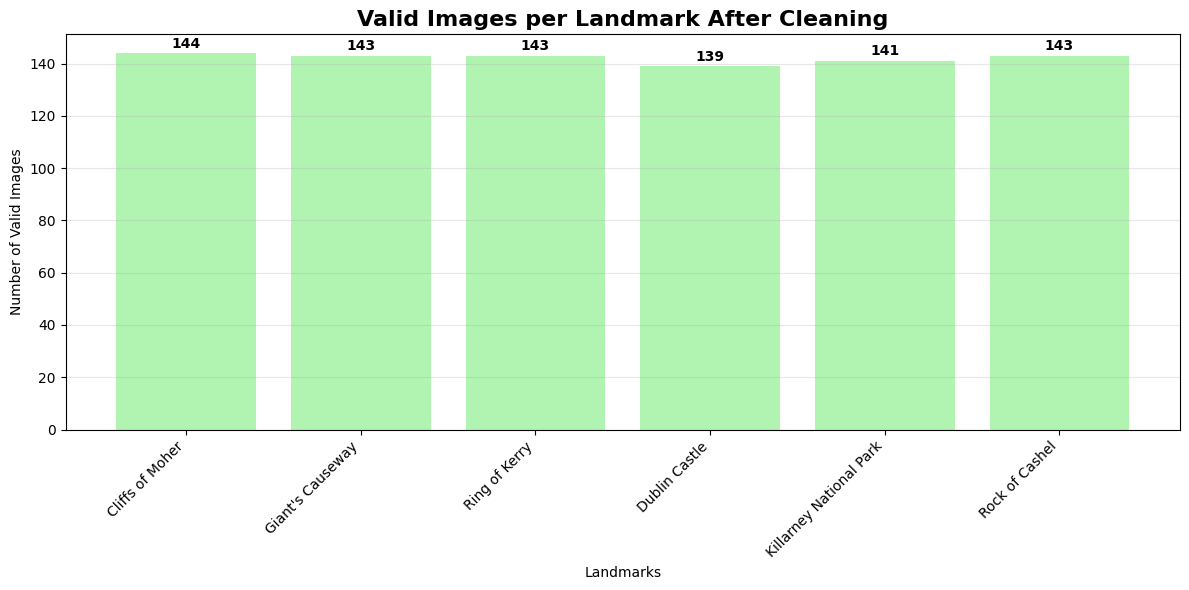

In [66]:
# CELL 6: Run Image Scraping
print(" AUTOMATED IMAGE SCRAPING")
print("=" * 35)

# Ask for confirmation
import sys
if 'google.colab' in sys.modules:
    # In Google Colab, proceed automatically
    proceed = True
else:
    # In local environment, ask for confirmation
    proceed = input("\nProceed with automated scraping? (y/n): ").lower() == 'y'

if proceed:
    print("\n Starting automated scraping...")
    
    # Initialize scraper
    scraper = EnhancedIrishLandmarkScraper(config)
    
    # Run scraping
    scraping_results = scraper.scrape_all_landmarks()
    
    # Display results
    scraper.display_scraping_stats(scraping_results)
    
    # Save scraping results
    results_path = config.DATA_DIR / "scraping_results.json"
    with open(results_path, 'w') as f:
        json.dump(scraping_results, f, indent=2)
    
    print(f"\n Scraping results saved to: {results_path}")
    
else:
    print("\n⏭ Skipping automated scraping")
    print(" You can manually collect images and place them in data/raw/ folders")
    
    # Create mock results for demonstration
    scraping_results = {
        landmark_key: {
            'name': landmark_info['name'],
            'downloaded': 0,
            'target': landmark_info['target_images']
        }
        for landmark_key, landmark_info in config.LANDMARKS.items()
    }

# CELL 7: Data Cleaning and Validation
print("\n DATA CLEANING AND VALIDATION")
print("=" * 35)

# Initialize cleaner
cleaner = DataCleaner(config)

# Clean all landmark folders
cleaning_results = cleaner.clean_all_landmarks()

# Visualize cleaning results
if any(result['valid_images'] > 0 for result in cleaning_results.values()):
    landmark_names = [result['name'] for result in cleaning_results.values()]
    valid_counts = [result['valid_images'] for result in cleaning_results.values()]
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(landmark_names, valid_counts, color='lightgreen', alpha=0.7)
    plt.title('Valid Images per Landmark After Cleaning', fontsize=16, fontweight='bold')
    plt.xlabel('Landmarks')
    plt.ylabel('Number of Valid Images')
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, count in zip(bars, valid_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print(" No valid images found after cleaning")

In [67]:
# CELL 8: Image Preprocessing and Resizing
class ImagePreprocessor:
    """Enhanced image preprocessing with quality improvements"""
    
    def __init__(self, config):
        self.config = config
        self.processing_stats = defaultdict(int)
    
    def preprocess_single_image(self, img_path, output_path):
        """Preprocess a single image with quality enhancements"""
        try:
            with Image.open(img_path) as img:
                # Convert to RGB
                img = img.convert('RGB')
                
                # Apply quality enhancements
                img = self.enhance_image_quality(img)
                
                # Resize with high-quality resampling
                img = img.resize(self.config.IMG_SIZE, Image.Resampling.LANCZOS)
                
                # Save with optimal quality
                img.save(output_path, 'JPEG', quality=95, optimize=True)
                
                self.processing_stats['successful'] += 1
                return True
                
        except Exception as e:
            self.processing_stats['failed'] += 1
            return False
    
    def enhance_image_quality(self, img):
        """Apply subtle quality enhancements"""
        try:
            from PIL import ImageEnhance
            
            # Subtle contrast enhancement
            enhancer = ImageEnhance.Contrast(img)
            img = enhancer.enhance(1.1)
            
            # Subtle color enhancement
            enhancer = ImageEnhance.Color(img)
            img = enhancer.enhance(1.05)
            
            # Subtle sharpness enhancement
            enhancer = ImageEnhance.Sharpness(img)
            img = enhancer.enhance(1.1)
            
            return img
            
        except Exception as e:
            # Return original if enhancement fails
            return img
    
    def preprocess_landmark_images(self, landmark_key):
        """Preprocess all images for a specific landmark"""
        raw_dir = self.config.RAW_DIR / landmark_key
        processed_dir = self.config.PROCESSED_DIR / landmark_key
        
        # Get all valid image files
        image_files = [f for f in raw_dir.glob("*") 
                      if f.suffix.lower() in self.config.IMG_FORMATS]
        
        if not image_files:
            print(f"⚠️ No images found for {landmark_key}")
            return 0
        
        print(f" Processing {len(image_files)} images for {landmark_key}...")
        
        successful_count = 0
        for i, img_path in enumerate(tqdm(image_files, desc="Processing")):
            output_path = processed_dir / f"{landmark_key}_{i:04d}.jpg"
            
            if self.preprocess_single_image(img_path, output_path):
                successful_count += 1
        
        print(f" Successfully processed: {successful_count}/{len(image_files)} images")
        return successful_count
    
    def preprocess_all_landmarks(self):
        """Preprocess images for all landmarks"""
        print(" Starting image preprocessing...")
        
        preprocessing_results = {}
        
        for landmark_key, landmark_info in self.config.LANDMARKS.items():
            processed_count = self.preprocess_landmark_images(landmark_key)
            preprocessing_results[landmark_key] = {
                'name': landmark_info['name'],
                'processed': processed_count
            }
        
        self.display_preprocessing_stats(preprocessing_results)
        return preprocessing_results
    
    def display_preprocessing_stats(self, results):
        """Display preprocessing statistics"""
        print("\n PREPROCESSING RESULTS")
        print("=" * 30)
        
        total_processed = 0
        for landmark_key, stats in results.items():
            print(f"{stats['name']}: {stats['processed']} images processed")
            total_processed += stats['processed']
        
        print(f"\nTotal processed: {total_processed}")
        print(f"Successful: {self.processing_stats['successful']}")
        print(f"Failed: {self.processing_stats['failed']}")

# Run preprocessing
preprocessor = ImagePreprocessor(config)
preprocessing_results = preprocessor.preprocess_all_landmarks()

 Starting image preprocessing...
 Processing 144 images for cliffs_of_moher...


Processing: 100%|██████████| 144/144 [00:03<00:00, 47.22it/s]


 Successfully processed: 144/144 images
 Processing 143 images for giants_causeway...


Processing: 100%|██████████| 143/143 [00:01<00:00, 78.11it/s]


 Successfully processed: 143/143 images
 Processing 143 images for ring_of_kerry...


Processing: 100%|██████████| 143/143 [00:03<00:00, 41.56it/s]


 Successfully processed: 143/143 images
 Processing 139 images for dublin_castle...


Processing: 100%|██████████| 139/139 [00:02<00:00, 64.22it/s]


 Successfully processed: 139/139 images
 Processing 141 images for killarney_national_park...


Processing: 100%|██████████| 141/141 [00:01<00:00, 80.29it/s]


 Successfully processed: 141/141 images
 Processing 143 images for rock_of_cashel...


Processing: 100%|██████████| 143/143 [00:01<00:00, 99.24it/s] 

 Successfully processed: 143/143 images

 PREPROCESSING RESULTS
Cliffs of Moher: 144 images processed
Giant's Causeway: 143 images processed
Ring of Kerry: 143 images processed
Dublin Castle: 139 images processed
Killarney National Park: 141 images processed
Rock of Cashel: 143 images processed

Total processed: 853
Successful: 853
Failed: 0


 Creating train/validation splits...
 Cliffs of Moher: 115 train, 29 val
 Giant's Causeway: 114 train, 29 val
 Ring of Kerry: 114 train, 29 val
 Dublin Castle: 111 train, 28 val
 Killarney National Park: 112 train, 29 val
 Rock of Cashel: 114 train, 29 val


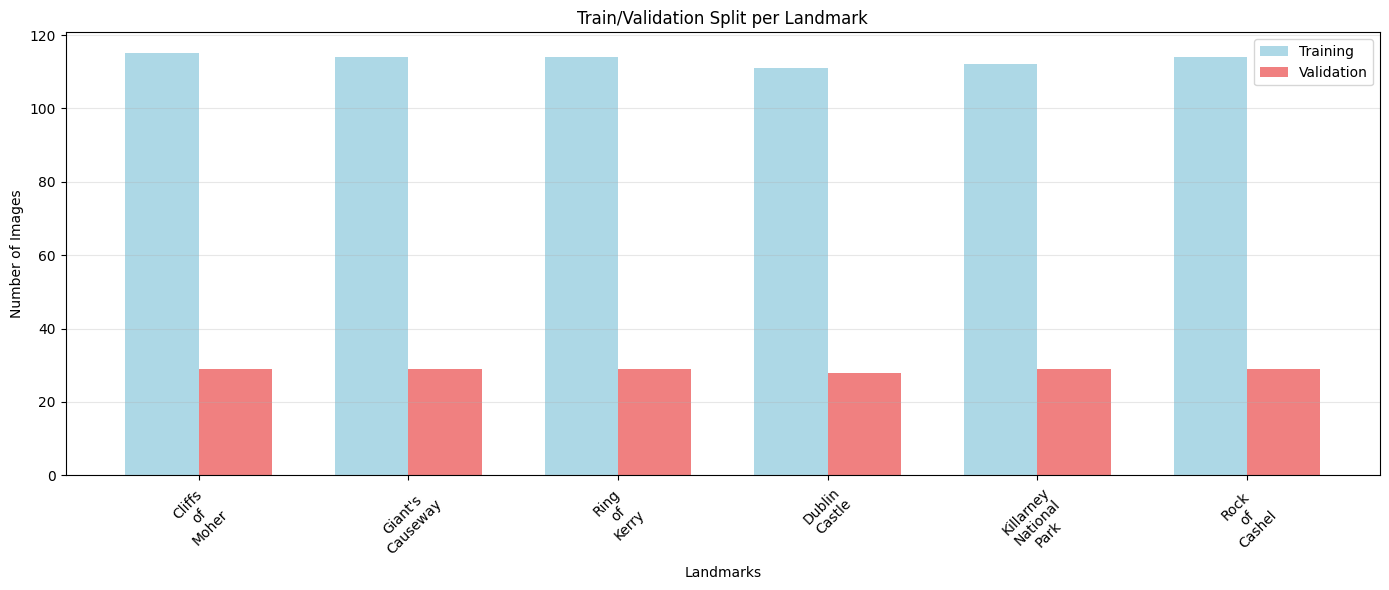

In [68]:
# CELL 9: Train/Validation Split Creation
def create_train_val_split(config, test_size=0.2, random_state=42):
    """Create train/validation splits for all landmarks"""
    print(" Creating train/validation splits...")
    
    split_results = {}
    
    for landmark_key, landmark_info in config.LANDMARKS.items():
        processed_dir = config.PROCESSED_DIR / landmark_key
        images = list(processed_dir.glob("*.jpg"))
        
        if len(images) < 10:
            print(f" Skipping {landmark_info['name']}: only {len(images)} images")
            continue
        
        # Create train/val directories
        train_dir = config.PROCESSED_DIR / "train" / landmark_key
        val_dir = config.PROCESSED_DIR / "val" / landmark_key
        train_dir.mkdir(parents=True, exist_ok=True)
        val_dir.mkdir(parents=True, exist_ok=True)
        
        # Split images
        train_images, val_images = train_test_split(
            images, test_size=test_size, random_state=random_state
        )
        
        # Copy images to respective directories
        for img_path in train_images:
            shutil.copy2(img_path, train_dir / img_path.name)
        
        for img_path in val_images:
            shutil.copy2(img_path, val_dir / img_path.name)
        
        split_results[landmark_key] = {
            'name': landmark_info['name'],
            'total': len(images),
            'train': len(train_images),
            'val': len(val_images)
        }
        
        print(f" {landmark_info['name']}: {len(train_images)} train, {len(val_images)} val")
    
    return split_results

# Create splits
split_results = create_train_val_split(config)

# Visualize split results
if split_results:
    landmarks = [info['name'] for info in split_results.values()]
    train_counts = [info['train'] for info in split_results.values()]
    val_counts = [info['val'] for info in split_results.values()]
    
    x = np.arange(len(landmarks))
    width = 0.35
    
    plt.figure(figsize=(14, 6))
    plt.bar(x - width/2, train_counts, width, label='Training', color='lightblue')
    plt.bar(x + width/2, val_counts, width, label='Validation', color='lightcoral')
    
    plt.xlabel('Landmarks')
    plt.ylabel('Number of Images')
    plt.title('Train/Validation Split per Landmark')
    plt.xticks(x, [name.replace(' ', '\n') for name in landmarks], rotation=45)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

 FINAL DATASET ANALYSIS
 Dataset Statistics:
   Total images: 794
   Training images: 633
   Validation images: 161
   Number of classes: 6
   Class balance ratio: 0.79
    Moderately balanced dataset

 Creating sample image grid...


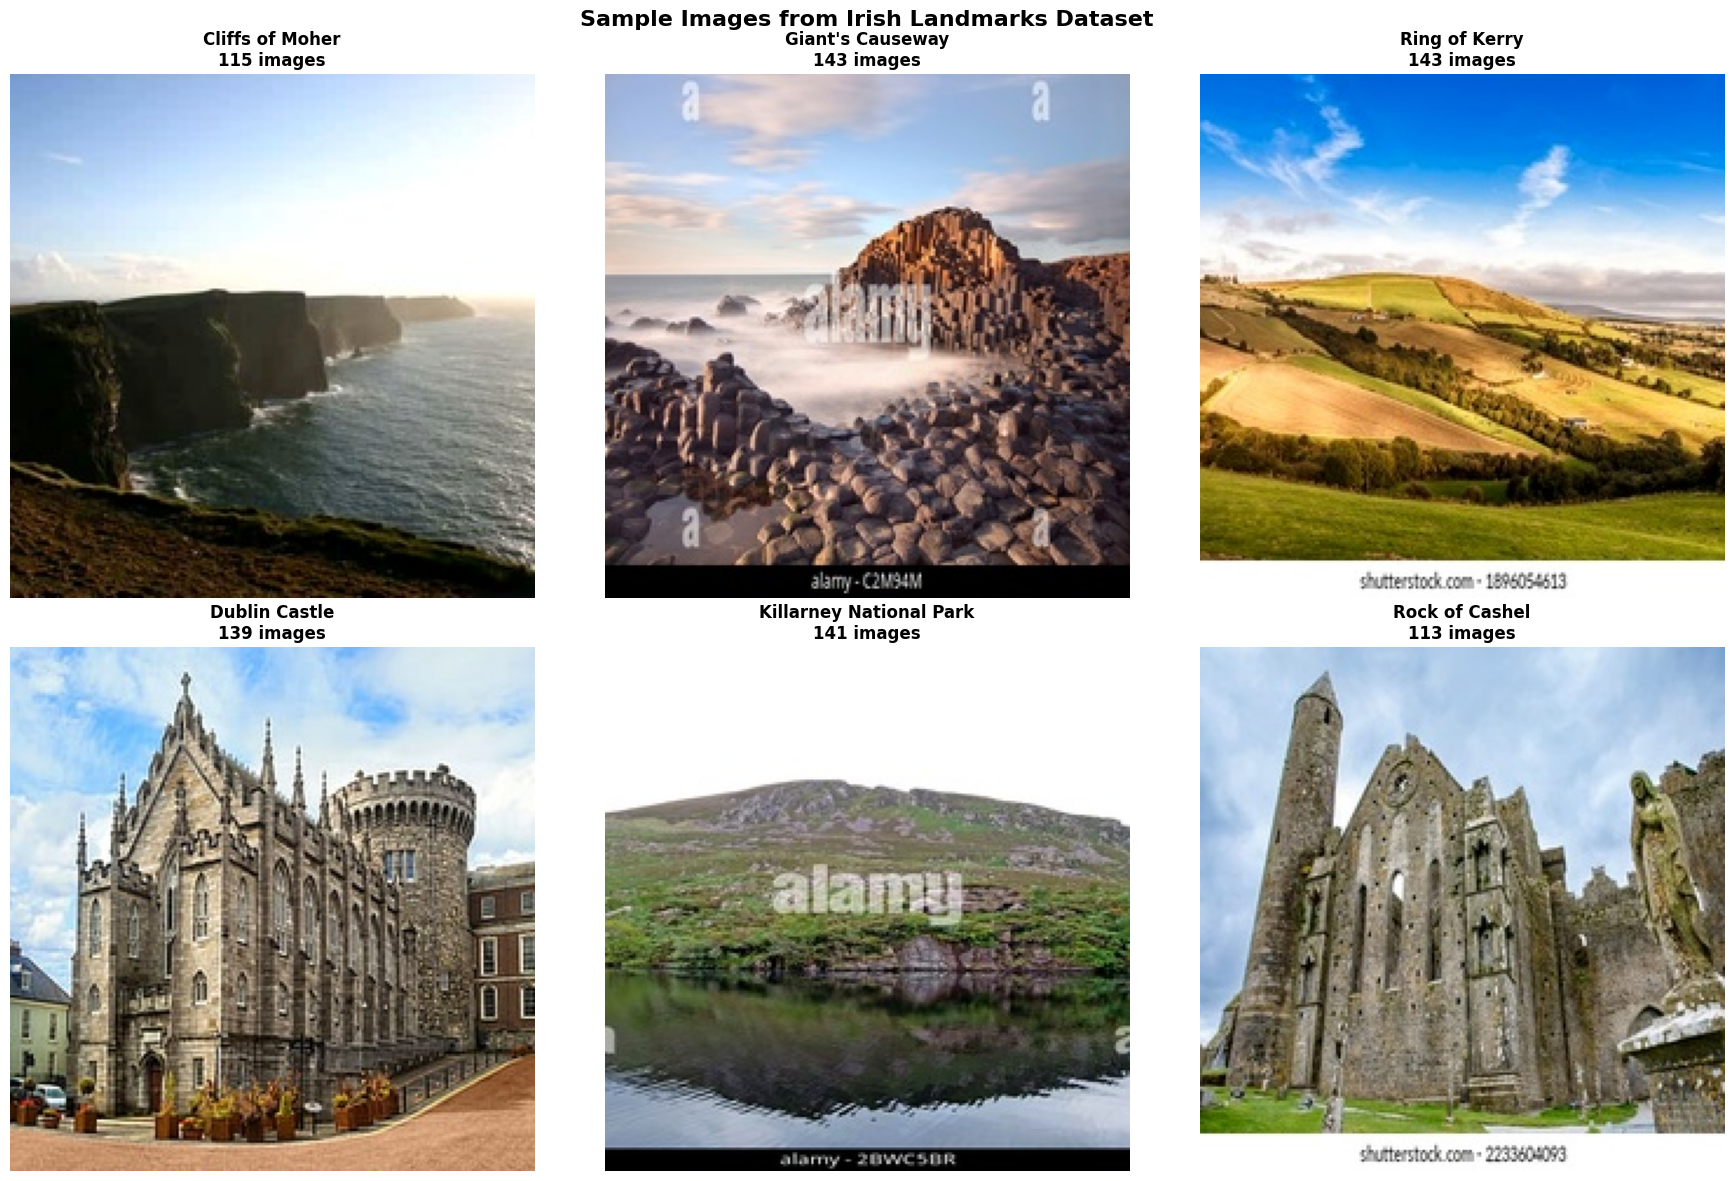

In [56]:
# CELL 10: Dataset Analysis and Visualization
def analyze_final_dataset(config, split_results):
    """Comprehensive dataset analysis"""
    print(" FINAL DATASET ANALYSIS")
    print("=" * 30)
    
    # Calculate statistics
    total_images = sum(info['total'] for info in split_results.values())
    total_train = sum(info['train'] for info in split_results.values())
    total_val = sum(info['val'] for info in split_results.values())
    
    print(f" Dataset Statistics:")
    print(f"   Total images: {total_images}")
    print(f"   Training images: {total_train}")
    print(f"   Validation images: {total_val}")
    print(f"   Number of classes: {len(split_results)}")
    
    # Check class balance
    class_sizes = [info['total'] for info in split_results.values()]
    balance_ratio = min(class_sizes) / max(class_sizes) if class_sizes else 0
    
    print(f"   Class balance ratio: {balance_ratio:.2f}")
    
    if balance_ratio > 0.8:
        print("    Well-balanced dataset")
    elif balance_ratio > 0.6:
        print("    Moderately balanced dataset")
    else:
        print("    Imbalanced dataset - consider collecting more images")
    
    # Create sample visualization
    create_sample_grid(config, split_results)

def create_sample_grid(config, split_results):
    """Create a grid showing sample images from each landmark"""
    print("\n Creating sample image grid...")
    
    n_landmarks = len(split_results)
    if n_landmarks == 0:
        print(" No landmarks with sufficient images")
        return
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, (landmark_key, landmark_info) in enumerate(split_results.items()):
        if idx >= len(axes):
            break
        
        # Get sample image from training set
        train_dir = config.PROCESSED_DIR / "train" / landmark_key
        images = list(train_dir.glob("*.jpg"))
        
        if images:
            sample_img_path = random.choice(images)
            
            try:
                img = Image.open(sample_img_path)
                axes[idx].imshow(img)
                axes[idx].set_title(f"{landmark_info['name']}\n{landmark_info['total']} images", 
                                  fontsize=12, fontweight='bold')
                axes[idx].axis('off')
            except Exception as e:
                axes[idx].text(0.5, 0.5, f"Error loading\n{landmark_info['name']}", 
                             ha='center', va='center', transform=axes[idx].transAxes)
                axes[idx].axis('off')
        else:
            axes[idx].text(0.5, 0.5, f"No images\n{landmark_info['name']}", 
                         ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(len(split_results), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Sample Images from Irish Landmarks Dataset', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Run final analysis
analyze_final_dataset(config, split_results)

In [69]:
# CELL 11: Save Dataset Metadata
def save_comprehensive_metadata(config, scraping_results, cleaning_results, 
                               preprocessing_results, split_results):
    """Save comprehensive dataset metadata"""
    
    metadata = {
        'dataset_info': {
            'name': 'Irish Landmarks Dataset',
            'description': 'Images of 6 famous Irish landmarks for deep learning classification',
            'created_date': pd.Timestamp.now().isoformat(),
            'version': '1.0'
        },
        'landmarks': config.LANDMARKS,
        'scraping_results': scraping_results,
        'cleaning_results': cleaning_results,
        'preprocessing_results': preprocessing_results,
        'split_results': split_results,
        'configuration': {
            'images_per_landmark': config.IMAGES_PER_LANDMARK,
            'image_size': config.IMG_SIZE,
            'min_image_size': config.MIN_IMG_SIZE,
            'max_file_size': config.MAX_FILE_SIZE,
            'split_ratio': '80/20 train/validation'
        },
        'statistics': {
            'total_landmarks': len(config.LANDMARKS),
            'total_images': sum(info.get('total', 0) for info in split_results.values()),
            'total_train': sum(info.get('train', 0) for info in split_results.values()),
            'total_val': sum(info.get('val', 0) for info in split_results.values())
        }
    }
    
    # Save metadata
    metadata_path = config.DATA_DIR / 'comprehensive_dataset_metadata.json'
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2, default=str)
    
    print(f" Comprehensive metadata saved to: {metadata_path}")
    return metadata

# Save metadata
dataset_metadata = save_comprehensive_metadata(
    config, scraping_results, cleaning_results, 
    preprocessing_results, split_results
)

 Comprehensive metadata saved to: data\comprehensive_dataset_metadata.json


In [70]:
 # CELL 12: Final Summary and Next Steps
print("\n DATA COLLECTION COMPLETE!")
print("=" * 40)

# Summary statistics
total_images = sum(info.get('total', 0) for info in split_results.values())
total_train = sum(info.get('train', 0) for info in split_results.values())
total_val = sum(info.get('val', 0) for info in split_results.values())

print(f" FINAL DATASET SUMMARY:")
print(f"   • Total images collected: {total_images}")
print(f"   • Training images: {total_train}")
print(f"   • Validation images: {total_val}")
print(f"   • Landmarks: {len(split_results)}")
print(f"   • Image format: {config.IMG_SIZE} RGB JPEG")


 DATA COLLECTION COMPLETE!
 FINAL DATASET SUMMARY:
   • Total images collected: 853
   • Training images: 680
   • Validation images: 173
   • Landmarks: 6
   • Image format: (224, 224) RGB JPEG
